## Create the environment, the buffer and the VAE

Create environment.

In [26]:
import gym

env = gym.make("PrivateEye-v4")


Choose the device.

In [27]:

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [28]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer


buffer = ReplayBuffer(10000, env.observation_space, env.action_space, device=device)

for episode in range(10):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

Create a categorical VAE.

In [29]:
from go_explore.categorical_vae import CategoricalVAE

vae = CategoricalVAE().to(device)

## Try the VAE

Sample a batch of observations.

In [30]:
input = buffer.sample(10).observations

Transpose, resize and psuh to the device.

In [31]:
from torchvision.transforms.functional import resize

input = input.moveaxis(-1, -3)
input = resize(input, (129, 129)).float() / 255

Build the reconstruction.

In [32]:
recons, logits = vae(input)

Visualize the result.

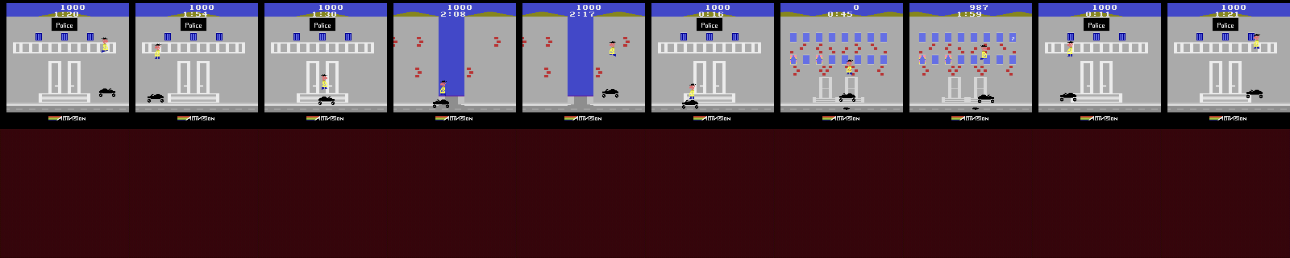

In [33]:
from go_explore.utils import build_image

build_image([input, recons])

Create the loss function.

In [34]:
import torch.nn.functional as F


def loss_func(input: torch.Tensor, recons: torch.Tensor, logits: torch.Tensor) -> torch.Tensor:
    # Reconstruction loss
    recons_loss = F.mse_loss(input, recons)

    # KL loss
    nb_classes = logits.shape[2]
    probs = F.softmax(logits, dim=2)
    latent_entropy = probs * torch.log(probs + 1e-10)
    target_entropy = probs * torch.log((1.0 / torch.tensor(nb_classes)))
    kl_loss = (latent_entropy - target_entropy).mean()

    # Total loss
    loss = recons_loss + 0.01 * kl_loss
    return loss, recons_loss, kl_loss

Test the loss function.

In [35]:
print(loss_func(input, recons, logits))

(tensor(0.2694, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.2694, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(1.6647e-06, device='cuda:0', grad_fn=<MeanBackward0>))


In [36]:
from torch import optim

buffer_size = 64
optimizer = optim.Adam(vae.parameters(), lr=2e-4)

# Used for visualisation at the end
test_image = buffer.sample(10).observations
test_image = test_image.moveaxis(-1, -3)
test_image = resize(test_image, (129, 129)).float() / 255
images = [test_image]

for epoch in range(5000):
    input = buffer.sample(10).observations
    input = input.moveaxis(-1, -3)
    input = resize(input, (129, 129)).float() / 255
    recons, logits = vae(input)
    loss, recons_loss, kl_loss = loss_func(input, recons, logits)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons loss: {:.5f}\tkl loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), kl_loss.item()
            ),
        )
        images.append(vae(test_image)[0])


epoch:     0	loss: 0.26348	recons loss: 0.26348	kl loss: 0.00000
epoch:  1000	loss: 0.00872	recons loss: 0.00834	kl loss: 0.03815
epoch:  2000	loss: 0.00564	recons loss: 0.00532	kl loss: 0.03174
epoch:  3000	loss: 0.00410	recons loss: 0.00376	kl loss: 0.03463
epoch:  4000	loss: 0.00315	recons loss: 0.00277	kl loss: 0.03788


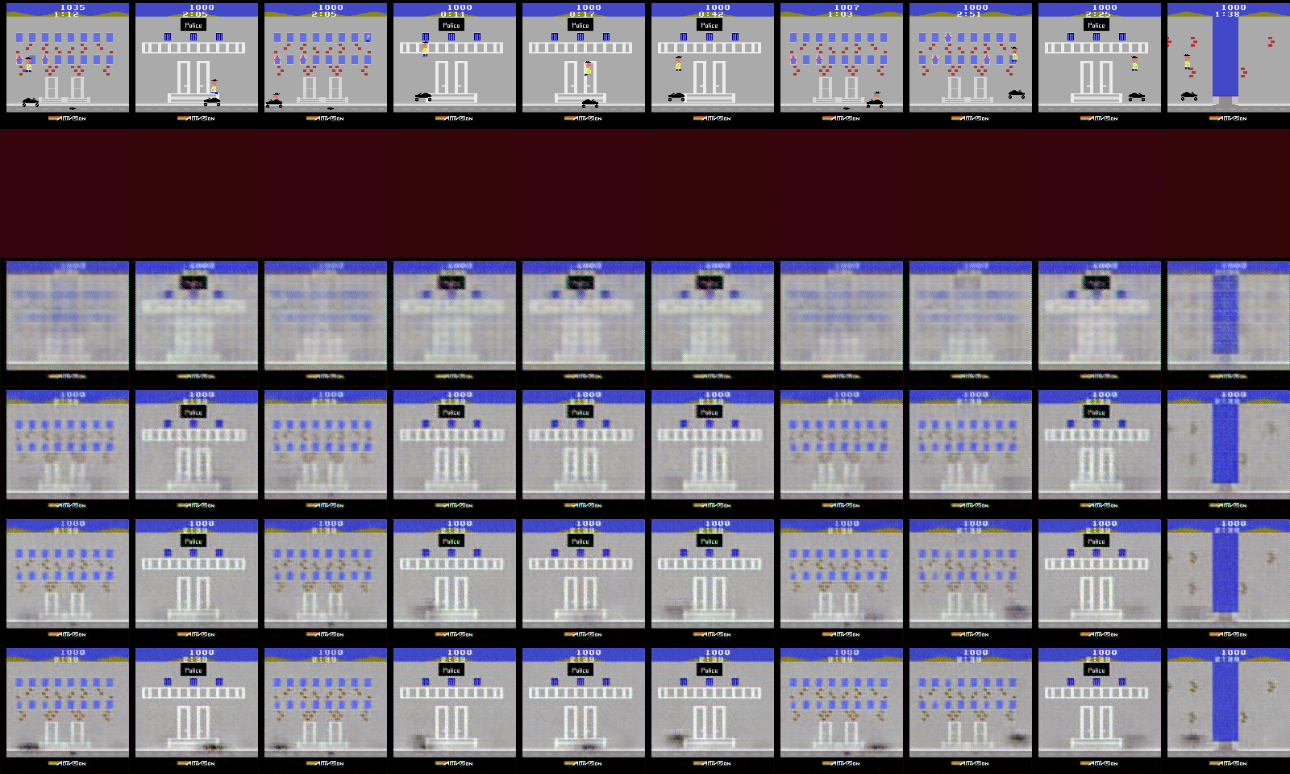

In [37]:
build_image(images)